### Endogenous dataset of on-target

In [1]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
def is_Exist_file(path):
    import os
    if os.path.exists(path):
        os.remove(path)


def mkdir(path):
    import os
    path = path.strip()
    path = path.rstrip("\\")
    isExists = os.path.exists(path)
    if not isExists:
        os.makedirs(path)


def walk(path):
    import os
    input_path_list = []
    if not os.path.exists(path):
        return -1
    for root, dirs, names in os.walk(path):
        for filename in names:
            input_path = os.path.join(root, filename)
            input_path_list.append(input_path)
    return input_path_list

### Plot

#### plot 1: scatter of engogenous targets between cells

In [3]:
# get data of systhesis and endogenous
def get_xy_systhesis_and_endo(data, cell, filter_count):
    if cell == 'K562':
        cols = ['sgRNA_id', '%s-Reads_aligned'%cell, '%s-indel_efficiency'%cell, 'indel_efficiency_std_k562']
    elif cell == 'H1':
        cols = ['sgRNA_id', '%s-Reads_aligned'%cell, '%s-indel_efficiency'%cell, 'indel_efficiency_std_h1']
    else:
        cols = ['sgRNA_id', '293T-Reads_aligned', '293T-indel_efficiency', 'indel_efficiency_std_k562']
    data = data.loc[data[cols[1]]>=filter_count, cols]
    data.dropna(inplace=True)
    data.reset_index(drop=True, inplace=True)
    print(data.shape)
    endo1, endo2 = cols[2], cols[3]
    data[endo1] = data[endo1].apply(lambda x: x*100)
    data[endo2] = data[endo2].apply(lambda x: x*100)
    x = data[endo1]
    y = data[endo2]
    return x, y


def generate_data(data, cell1, cell2, filter_count):
    endo1 = '%s-indel_efficiency'%cell1
    endo2 = '%s-indel_efficiency'%cell2
    data = data.loc[data['%s-Reads_aligned'%cell1] >= filter_count, :]
    data = data.loc[data['%s-Reads_aligned'%cell2] >= filter_count, :]
    data = data[[endo1, endo2]]
    #
    data.dropna(inplace=True)
    data.reset_index(drop=True, inplace=True)
    data[endo1] = data[endo1].apply(lambda x: x*100)
    data[endo2] = data[endo2].apply(lambda x: x*100)
    x = data[endo1]
    y = data[endo2]
    return x, y

def linear_fit(x, y):
    ## 拟合线性回归
    from sklearn.externals import joblib
    from sklearn import linear_model
    import numpy as np
    X = np.asarray(x).reshape(-1, 1)
    Y = np.asarray(y).reshape(-1, 1)
    model = linear_model.LinearRegression()
    model.fit(X,Y)
    x0, x1 = 0, 100
    y0 = model.predict(np.array([x0]).reshape(-1, 1))[0][0]
    y1 = model.predict(np.array([x1]).reshape(-1, 1))[0][0]
    plot_points = ([x0, x1], [y0, y1])
    return plot_points


def plot_corr_endo_and_inte(x, y, filter_count, 
                            xlabel, ylabel, save_path, textYN=True):
    # plot data
    plot_points = linear_fit(x, y)
    pear = x.corr(y, method='pearson')
    spear = x.corr(y, method='spearman')

    import matplotlib.pyplot as plt
    # 设置默认绘图风格
    plt.style.use("seaborn-white")  
    fig, ax = plt.subplots(1,1, figsize=(4, 4))
    plt.scatter(x, y, s=8, color='dimgray')
    plt.plot(plot_points[0], plot_points[1], color='dimgray', linewidth=3)
    # 为坐标轴设置名称
    plt.xlabel(xlabel, fontsize=12, weight='bold')
    plt.ylabel(ylabel, fontsize=12, weight='bold')
#     # text
#     plt.text(5, 60, "Filter reads: %s, num. of gRNAs: %s"%(filter_count, len(x)), weight='bold')
#     plt.text(5, 55, "Pearson = %s"%(round(pear, 2)), weight='bold')
#     plt.text(5, 50, "Spearman = %s"%(round(spear, 2)), weight='bold')
    # for 20220303
    # text
    if textYN:
        plt.text(5, 95, "Filter reads: %s"%(filter_count), weight='bold')
        plt.text(5, 90, "num. of gRNAs: %s"%(len(x)), weight='bold')
        plt.text(5, 85, "Pearson = %s"%(round(pear, 2)), weight='bold')
        plt.text(5, 80, "Spearman = %s"%(round(spear, 2)), weight='bold')
    else:
        plt.text(60, 35, "Filter reads: %s"%(filter_count), weight='bold')
        plt.text(60, 30, "num. of gRNAs: %s"%(len(x)), weight='bold')
        plt.text(60, 25, "Pearson = %s"%(round(pear, 2)), weight='bold')
        plt.text(60, 20, "Spearman = %s"%(round(spear, 2)), weight='bold')
    # lim
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    ## 坐标轴不可见
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # title
    # plt.title(title, weight='bold')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

In [4]:
main_path = "../../data"
os.chdir(main_path)

figsuplix = 'pdf'

/Users/yanjf/opt/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


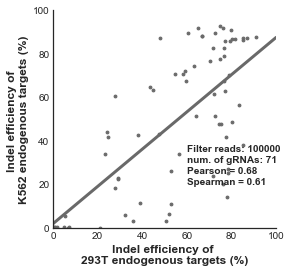

In [5]:
# scatter of engogenous targets between cells
data_dir = "./On-Target/Endo_data"
data = pd.read_excel(data_dir + "/self-endogenous on-target dataset.xlsx")
cell1 = '293T'
cell2 = 'K562'
filter_count = 100000
xlabel = "Indel efficiency of \n%s endogenous targets (%%)"%cell1
ylabel = "Indel efficiency of \n%s endogenous targets (%%)"%cell2

# plot
x, y = generate_data(data, cell1, cell2, filter_count)
savefig_dir = "./%s/on-target/Endo-anlysis/correlation_endo_targets_between_cells"%figsuplix
mkdir(savefig_dir)
save_path = savefig_dir + '/scatter of engogenous targets between %s and %s.%s'%(cell1, cell2, figsuplix)
plot_corr_endo_and_inte(x, y, filter_count, 
                        xlabel, ylabel, save_path, textYN=False)

##### plot 2: distribution

In [6]:
# For 20220303
def generate_single_cell_data(data, cell, filter_count):
    endo = '%s-indel_efficiency'%cell
    data0 = data.loc[data['%s-Reads_aligned'%cell] >= filter_count, ['sgRNA_id', 'gRNA sequence',
                                                                     endo, '%s-Reads_aligned'%cell]]
    data0.dropna(inplace=True)
    data0.reset_index(drop=True, inplace=True)
    data0[endo] = data0[endo].apply(lambda x: x*100)
    x = data0[endo]
    return x


## 
def plot_distribution(data, cells, savefig_dir):
    import seaborn as sns
    import matplotlib.pyplot as plt

    # 设置默认绘图风格
    plt.style.use("seaborn-white")  
    fig, ax = plt.subplots(1,1, figsize=(6, 4))
    ## 坐标轴不可见
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    colors = ['royalblue','darkorange','lightgreen','teal','palevioletred','pink', 
              'maroon','blueviolet','indigo','darkorchid','mediumorchid','thistle',
              'plum','violet','purple','m','lightseagreen','magenta',
              'orchid','chartreuse','deeppink','hotpink']
    colors = ['teal', 'pink', 'blueviolet']
    for i, cell in enumerate(cells):
        c = colors[i]
        plt.bar([0], [0], label=cell, fc=c)
        y1 = generate_single_cell_data(data, cell, filter_count)
        sns.distplot(y1, hist=False, color=c)
    # 为坐标轴设置名称
    plt.xlabel("Efficiency (%)", fontsize=12, weight='bold')
    plt.ylabel("Density", fontsize=12, weight='bold')
    plt.legend(loc='upper right', fontsize=9, prop={'weight': 'bold'})
    save_path = savefig_dir + "/distribution of indel efficiency at endogenous targets.%s"%figsuplix
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

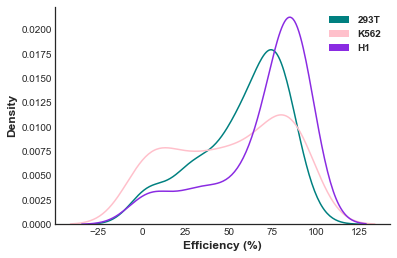

In [7]:
# plot
data_dir = "./On-Target/Endo_data"
data = pd.read_excel(data_dir + "/self-endogenous on-target dataset.xlsx")
#
filter_count = 100000
cells = ['293T', 'K562', 'H1']
savefig_dir = "./%s/on-target/Endo-anlysis"%figsuplix
plot_distribution(data, cells, savefig_dir)

##### plot 3 comparison with other models

In [8]:
# get heatmap data
def obtain_heatmap_data_fun(data, corr_label, filter_count, selective_models_for_comparison, endo_cells, 
                            same_targets=False):
    # dataset_cols = ['293T-indel_efficiency', 'K562-indel_efficiency', 'H1-indel_efficiency']
    cdata_list = []
    cdata_index = []
    dataset_cols = []
    gRNAs_num_dict = {}
    a = 0
    for cell in endo_cells:
        dataset_cols.append('%s-indel_efficiency'%cell)
        cdata0 = data.loc[data['%s-Reads_aligned'%cell]>=filter_count, :]
        cdata0 = cdata0.loc[:, selective_models_for_comparison + ['%s-indel_efficiency'%cell]]
        cdata1 = cdata0.corr(method=corr_label)
        if a == 0:
            a = 1
        else:
            cdata1.drop(selective_models_for_comparison, inplace=True)
        del cdata1['%s-indel_efficiency'%cell]
        cdata_list.append(cdata1)
        gRNAs_num_dict[cell] = cdata0.shape[0]
        cdata_index.append('Endo %s-%s'%(cell, cdata0.shape[0]))
    print("filter count:", filter_count, "; data.shape:", data.shape)
    cdata = pd.concat(cdata_list, axis=0)
    cdata = cdata.loc[dataset_cols, selective_models_for_comparison]
    # change index
    cdata.index = cdata_index
    # get mask data
    import copy
    mask_data = copy.deepcopy(cdata)
    mask_data.loc[:,:] = 0
    return cdata, mask_data, gRNAs_num_dict


## plot heatmap
def plot_single_heatmap_for_comparison(data, mask_data, model_list, 
                                         title, savefig_path, vmax=0.67, figsize=(10,5), cmap='coolwarm'):
    import seaborn as sns; sns.set()
    from matplotlib import pyplot as plt

    data = data[model_list]
    mask_data = mask_data[model_list]
    
    sns.set_style("darkgrid")
    f, ax = plt.subplots(figsize=figsize)
    ax = sns.heatmap(data, mask=np.array(mask_data), cbar=True, cmap=cmap, vmax=vmax,
                     linewidths=0.01)

    ## text
    cols = data.columns.tolist()
    total_row_num = len(data)
    row_num = -1
    for index, row in data.iterrows():
        row_num += 1
        for index, col in enumerate(cols):
            plt.text(index+0.25, row_num+0.5, str(round(row[col], 3)), fontsize=12)
    plt.title(title, fontsize=12, weight='bold')
    plt.xticks(fontsize=12, weight='bold')
    plt.yticks(fontsize=12, weight='bold', rotation=0)
    plt.savefig(savefig_path, dpi=300, bbox_inches = 'tight')
    plt.show()

filter count: 100000 ; data.shape: (78, 30)


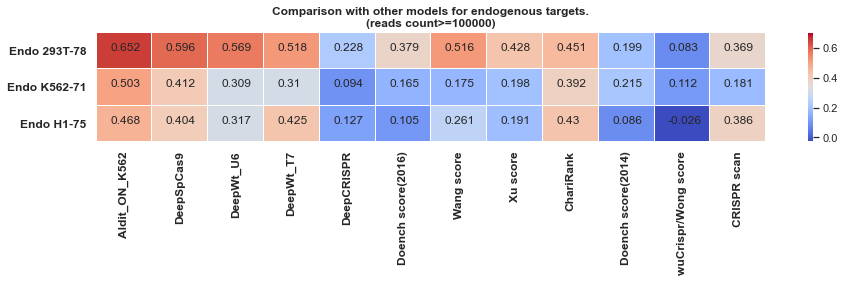

In [9]:
# plot
corr_label = 'spearman'
data_dir = "./On-Target/Endo_data"
savefig_dir = "./%s/on-target/Endo-anlysis/heatmap"%figsuplix
mkdir(savefig_dir)
endo_cells = ['293T', 'K562', 'H1']
filter_count = 100000
data = pd.read_excel(data_dir + "/self-endogenous on-target dataset.xlsx")
data.rename(columns={'K562_ypred': 'AIdit_ON_K562', 
                     'Jurkat_ypred': 'AIdit_ON_Jurkat'
                    }, inplace=True)
selective_models_for_comparison = ['AIdit_ON_K562', 
                                   'DeepSpCas9', 'DeepWt_U6', 'DeepWt_T7', 'DeepCRISPR', 
                                   'Doench score(2016)', 'Wang score', 'Xu score', 'ChariRank', 
                                   'Doench score(2014)', 'wuCrispr/Wong score', 'CRISPR scan']
# get data & mask_data
cdata, mask_data, gRNAs_num_dict = obtain_heatmap_data_fun(data, corr_label, filter_count, 
                                                           selective_models_for_comparison, endo_cells)
# plot
title = "Comparison with other models for endogenous targets.\n(reads count>=%s)"%(filter_count)
savefig_path = savefig_dir + '/Comparison with other models for endo targets-reads%s.%s'%(filter_count, figsuplix)
plot_single_heatmap_for_comparison(cdata, mask_data, selective_models_for_comparison, 
                                         title, savefig_path, vmax=0.7, figsize=(15,2), cmap='coolwarm')